# Semantic Segmentation

**Segmentation** is one of the main computer vision task. For **each** pixel of image you must specify class(background included). Semantic segmentation only tells pixel class, instance segmentation divide classes into different instances. 

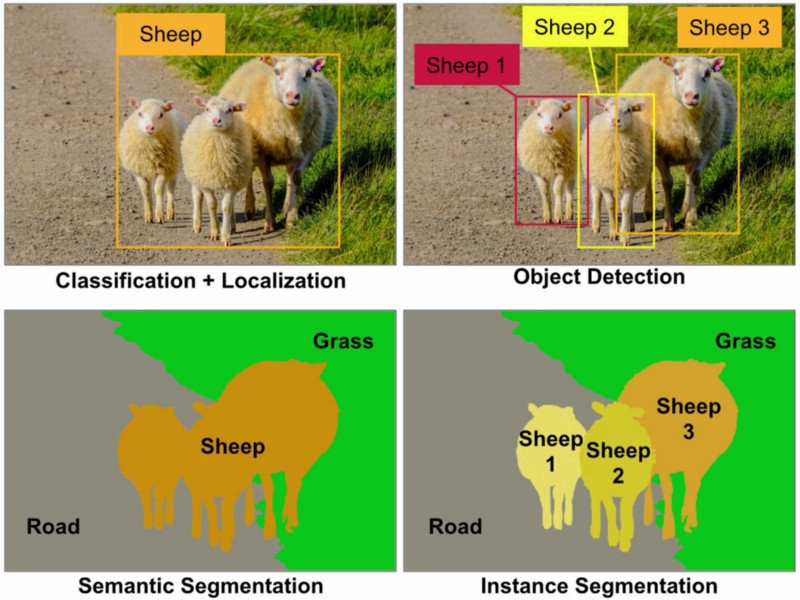

For instance segmentation ten cars is **different** objects, for semantic segmentation **all** cars is one class.


Almost all architectures have same structure. First part is **encoder** that extracts features from input image, second part is **decoder** that transforms this features into image with same height and width and some number of channels, may be equal to classes count.



In [1]:
import tensorflow as tf
import tensorflow.keras.layers as keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import os
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
train_size = 0.8
lr = 3e-4
weight_decay = 8e-9
batch_size = 64
epochs = 100

## Dataset

In [3]:
!apt-get install rar
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
!unrar x -Y PH2Dataset.rar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  rar
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 295 kB of archives.
After this operation, 799 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 rar amd64 2:5.5.0-1 [295 kB]
Fetched 295 kB in 1s (203 kB/s)
Selecting previously unselected package rar.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../rar_2%3a5.5.0-1_amd64.deb ...
Unpacking rar (2:5.5.0-1) ...
Setting up rar (2:5.5.0-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
--2022-08-24 19:24:50--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18

In [4]:
def load_dataset(train_part, root='PH2Dataset'):
    images = []
    masks = []

    for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
        if root.endswith('_Dermoscopic_Image'):
            images.append(imread(os.path.join(root, files[0])))
        if root.endswith('_lesion'):
            masks.append(imread(os.path.join(root, files[0])))

    size = (256, 256)
    images = np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])
    masks = np.expand_dims(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks]), axis=3)

    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    X_train = tf.cast(images[train_ind, :, :, :], tf.float32)
    y_train = tf.cast(masks[train_ind, :, :, :], tf.float32)

    X_test = tf.cast(images[test_ind, :, :, :], tf.float32)
    y_test = tf.cast(masks[test_ind, :, :, :], tf.float32)

    return (X_train, y_train), (X_test, y_test)

In [5]:
(X_train, y_train), (X_test, y_test) = load_dataset(train_size)

In [6]:
def plotn(n, data):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        ax[i].imshow(img)
        ax1[i].imshow(mask[:, :, 0])
    plt.show()

**Let's plot some images with corresponding masks.**

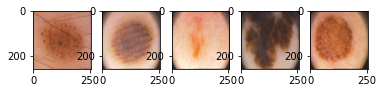

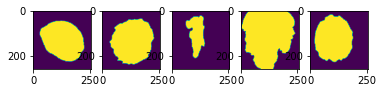

In [7]:
plotn(5, (X_train, y_train))

## SegNet

Simple encoder - decoder architecture with convolutions, poolings in encoder and convolutions, upsamplings in decoder.

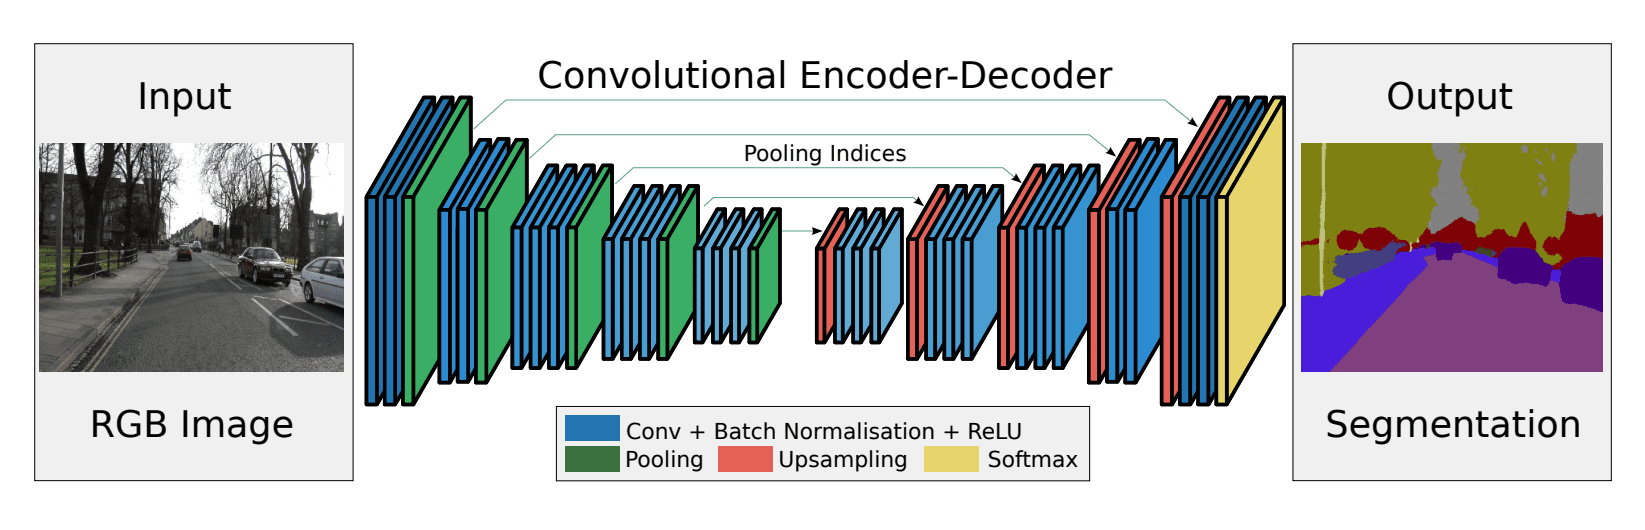

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [8]:
class SegNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = keras.Conv2D(16, kernel_size=3, padding='same')
        self.bn0 = keras.BatchNormalization()
        self.relu0 = keras.Activation('relu')
        self.pool0 = keras.MaxPool2D()

        self.enc_conv1 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.relu1 = keras.Activation('relu')
        self.bn1 = keras.BatchNormalization()
        self.pool1 = keras.MaxPool2D()

        self.enc_conv2 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.relu2 = keras.Activation('relu')
        self.bn2 = keras.BatchNormalization()
        self.pool2 = keras.MaxPool2D()

        self.enc_conv3 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.relu3 = keras.Activation('relu')
        self.bn3 = keras.BatchNormalization()
        self.pool3 = keras.MaxPool2D()

        self.bottleneck_conv = keras.Conv2D(256, kernel_size=(3, 3), padding='same')

        self.upsample0 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv0 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.dec_relu0 = keras.Activation('relu')
        self.dec_bn0 = keras.BatchNormalization()

        self.upsample1 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv1 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.dec_relu1 = keras.Activation('relu')
        self.dec_bn1 = keras.BatchNormalization()

        self.upsample2 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv2 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.dec_relu2 = keras.Activation('relu')
        self.dec_bn2 = keras.BatchNormalization()

        self.upsample3 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv3 = keras.Conv2D(1, kernel_size=1)

    def call(self, input):
        e0 = self.pool0(self.relu0(self.bn0(self.enc_conv0(input))))
        e1 = self.pool1(self.relu1(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(self.relu2(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(self.relu3(self.bn3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_relu0(self.dec_bn0(self.upsample0(self.dec_conv0(b))))
        d1 = self.dec_relu1(self.dec_bn1(self.upsample1(self.dec_conv1(d0))))
        d2 = self.dec_relu2(self.dec_bn2(self.upsample2(self.dec_conv2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))

        return d3

In [9]:
model = SegNet()
optimizer = optimizers.Adam(learning_rate=lr, decay=weight_decay)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer)

In [10]:
def train(datasets, model, epochs, batch_size):
    train_dataset, test_dataset = datasets[0], datasets[1]

    model.fit(train_dataset[0], train_dataset[1],
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_dataset[0], test_dataset[1]))

In [11]:
train(((X_train, y_train), (X_test, y_test)), model, epochs, batch_size)

Epoch 1/100
3/3 [==============================] - 20s 1s/step - loss: 0.6211 - val_loss: 0.6956
Epoch 2/100
3/3 [==============================] - 1s 191ms/step - loss: 0.3327 - val_loss: 0.6892
Epoch 3/100
3/3 [==============================] - 1s 193ms/step - loss: 0.2743 - val_loss: 0.6782
Epoch 4/100
3/3 [==============================] - 1s 190ms/step - loss: 0.2552 - val_loss: 0.6669
Epoch 5/100
3/3 [==============================] - 1s 191ms/step - loss: 0.2297 - val_loss: 0.6556
Epoch 6/100
3/3 [==============================] - 1s 188ms/step - loss: 0.2134 - val_loss: 0.6459
Epoch 7/100
3/3 [==============================] - 1s 188ms/step - loss: 0.1975 - val_loss: 0.6410
Epoch 8/100
3/3 [==============================] - 1s 187ms/step - loss: 0.1995 - val_loss: 0.6385
Epoch 9/100
3/3 [==============================] - 1s 188ms/step - loss: 0.1877 - val_loss: 0.6372
Epoch 10/100
3/3 [==============================] - 1s 187ms/step - loss: 0.1842 - val_loss: 0.6362
Epoch 11/10

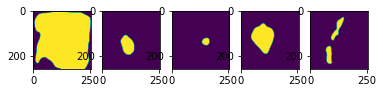

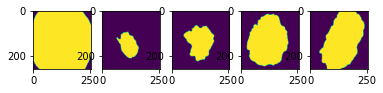

In [12]:
predictions = []
image_mask = []
plots = 5

for i, (img, mask) in enumerate(zip(X_test, y_test)):
    if i == plots:
        break
    img = tf.expand_dims(img, 0)
    pred = np.array(model.predict(img))
    predictions.append(pred[0, :, :, 0] > 0.5)
    image_mask.append(mask)
plotn(plots, (predictions, image_mask))

## U-Net

Very simple architecture that uses skip connections. Skip connections at each convolution level helps network doesn't lost information about features from original input at this level.

U-Net usually has a default encoder for feature extraction, for example resnet50.

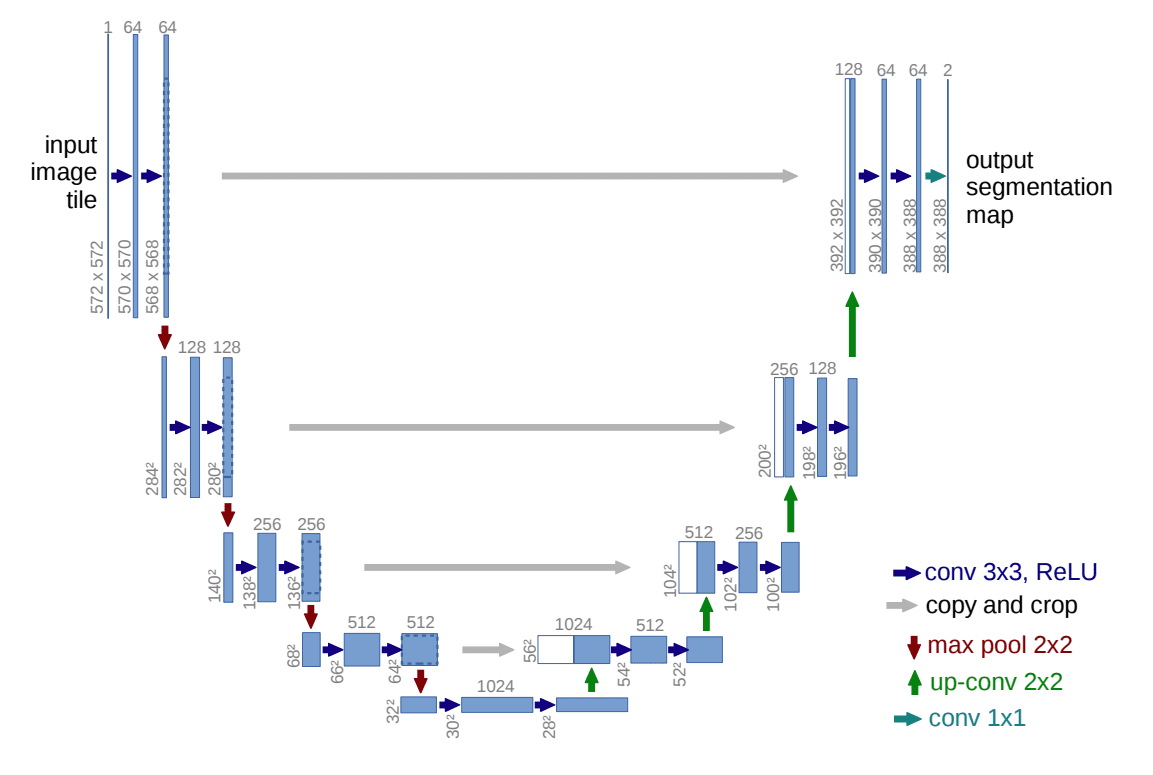

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. [U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)

In [13]:
class UNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = keras.Conv2D(16, kernel_size=3, padding='same')
        self.bn0 = keras.BatchNormalization()
        self.relu0 = keras.Activation('relu')
        self.pool0 = keras.MaxPool2D()

        self.enc_conv1 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.relu1 = keras.Activation('relu')
        self.bn1 = keras.BatchNormalization()
        self.pool1 = keras.MaxPool2D()

        self.enc_conv2 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.relu2 = keras.Activation('relu')
        self.bn2 = keras.BatchNormalization()
        self.pool2 = keras.MaxPool2D()

        self.enc_conv3 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.relu3 = keras.Activation('relu')
        self.bn3 = keras.BatchNormalization()
        self.pool3 = keras.MaxPool2D()

        self.bottleneck_conv = keras.Conv2D(256, kernel_size=(3, 3), padding='same')

        self.upsample0 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv0 = keras.Conv2D(128, kernel_size=3, padding='same', input_shape=[None, 384, None, None])
        self.dec_relu0 = keras.Activation('relu')
        self.dec_bn0 = keras.BatchNormalization()

        self.upsample1 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv1 = keras.Conv2D(64, kernel_size=3, padding='same', input_shape=[None, 192, None, None])
        self.dec_relu1 = keras.Activation('relu')
        self.dec_bn1 = keras.BatchNormalization()

        self.upsample2 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv2 = keras.Conv2D(32, kernel_size=3, padding='same', input_shape=[None, 96, None, None])
        self.dec_relu2 = keras.Activation('relu')
        self.dec_bn2 = keras.BatchNormalization()

        self.upsample3 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv3 = keras.Conv2D(1, kernel_size=1, input_shape=[None, 48, None, None])

        self.cat0 = keras.Concatenate(axis=3)
        self.cat1 = keras.Concatenate(axis=3)
        self.cat2 = keras.Concatenate(axis=3)
        self.cat3 = keras.Concatenate(axis=3)

    def call(self, input):
        e0 = self.pool0(self.relu0(self.bn0(self.enc_conv0(input))))
        e1 = self.pool1(self.relu1(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(self.relu2(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(self.relu3(self.bn3(self.enc_conv3(e2))))

        cat0 = self.relu0(self.bn0(self.enc_conv0(input)))
        cat1 = self.relu1(self.bn1(self.enc_conv1(e0)))
        cat2 = self.relu2(self.bn2(self.enc_conv2(e1)))
        cat3 = self.relu3(self.bn3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        cat_tens0 = self.cat0([self.upsample0(b), cat3])
        d0 = self.dec_relu0(self.dec_bn0(self.dec_conv0(cat_tens0)))

        cat_tens1 = self.cat1([self.upsample1(d0), cat2])
        d1 = self.dec_relu1(self.dec_bn1(self.dec_conv1(cat_tens1)))

        cat_tens2 = self.cat2([self.upsample2(d1), cat1])
        d2 = self.dec_relu2(self.dec_bn2(self.dec_conv2(cat_tens2)))

        cat_tens3 = self.cat3([self.upsample3(d2), cat0])
        d3 = self.dec_conv3(cat_tens3)

        return d3

In [14]:
model = UNet()
optimizer = optimizers.Adam(learning_rate=lr, decay=weight_decay)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer)

In [15]:
train(((X_train, y_train), (X_test, y_test)), model, epochs, batch_size)

Epoch 1/100
3/3 [==============================] - 9s 2s/step - loss: 0.5476 - val_loss: 0.6260
Epoch 2/100
3/3 [==============================] - 1s 360ms/step - loss: 0.2990 - val_loss: 0.6223
Epoch 3/100
3/3 [==============================] - 1s 357ms/step - loss: 0.2570 - val_loss: 0.6165
Epoch 4/100
3/3 [==============================] - 1s 358ms/step - loss: 0.2424 - val_loss: 0.6090
Epoch 5/100
3/3 [==============================] - 1s 358ms/step - loss: 0.2186 - val_loss: 0.6034
Epoch 6/100
3/3 [==============================] - 1s 384ms/step - loss: 0.2057 - val_loss: 0.5974
Epoch 7/100
3/3 [==============================] - 1s 358ms/step - loss: 0.1951 - val_loss: 0.5930
Epoch 8/100
3/3 [==============================] - 1s 359ms/step - loss: 0.1946 - val_loss: 0.5899
Epoch 9/100
3/3 [==============================] - 1s 363ms/step - loss: 0.1835 - val_loss: 0.5837
Epoch 10/100
3/3 [==============================] - 1s 359ms/step - loss: 0.1788 - val_loss: 0.5742
Epoch 11/100

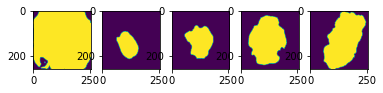

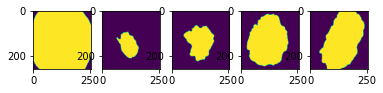

In [16]:
predictions = []
image_mask = []
plots = 5

for i, (img, mask) in enumerate(zip(X_test, y_test)):
    if i == plots:
        break
    img = tf.expand_dims(img, 0)
    pred = np.array(model.predict(img))
    predictions.append(pred[0, :, :, 0] > 0.5)
    image_mask.append(mask)
plotn(plots, (predictions, image_mask))